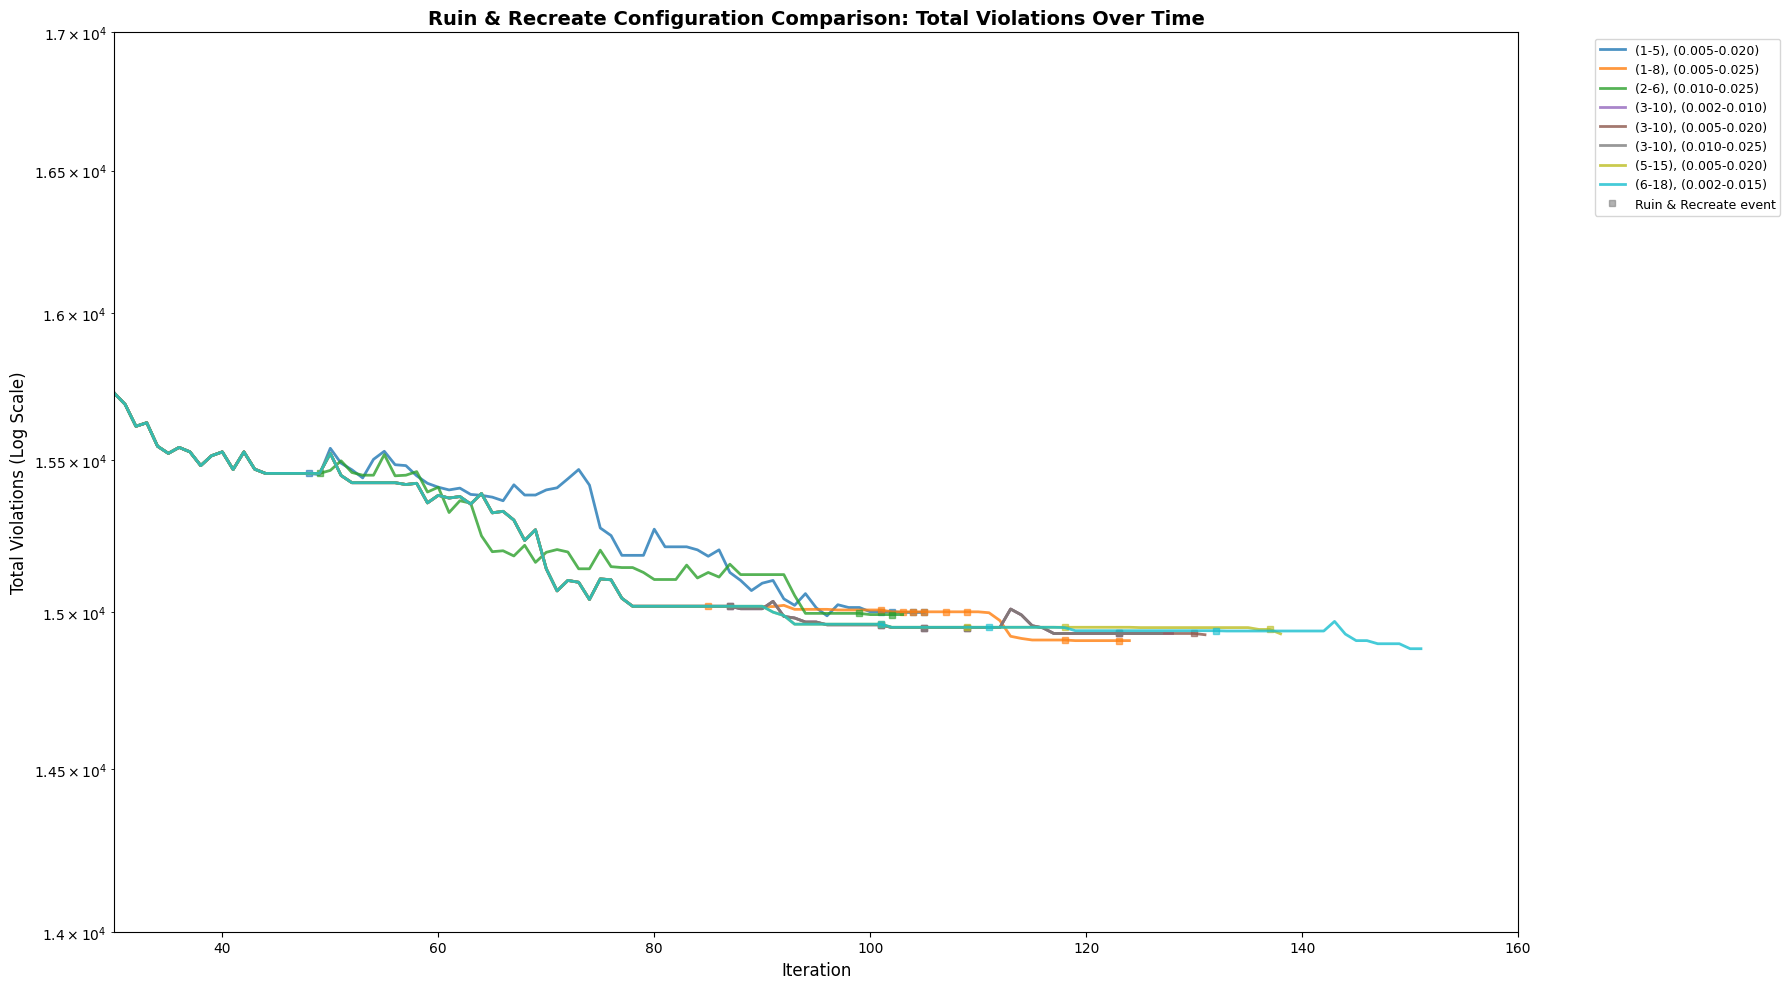

In [32]:
import matplotlib.pyplot as plt
import re
import numpy as np
import os
from pathlib import Path

def parse_ruin_recreate_log(log_text):
    """Parse a single log file to extract iteration and violation data."""
    lines = log_text.strip().split('\n')
    
    iterations = []
    total_violations = []
    hard_violations = []
    reheating_iterations = []
    ruin_iterations = []
    
    current_iteration = None
    
    for line in lines:
        # Match iteration lines with violations
        iteration_match = re.search(r'Iteration: (\d+),.*\(Hard: (\d+), Medium: (\d+), Soft: (\d+)\)', line)
        if iteration_match:
            iteration = int(iteration_match.group(1))
            hard = int(iteration_match.group(2))
            medium = int(iteration_match.group(3))
            soft = int(iteration_match.group(4))
            total = hard + medium + soft
            
            iterations.append(iteration)
            total_violations.append(total)
            hard_violations.append(hard)
            current_iteration = iteration
        
        # Detect reheating
        if "Reheating" in line and current_iteration is not None:
            reheating_iterations.append(current_iteration)
        
        # Detect ruin and recreate
        if "Ruin and Recreate successful" in line and current_iteration is not None:
            ruin_iterations.append(current_iteration)
    
    return {
        'iterations': iterations,
        'total_violations': total_violations,
        'hard_violations': hard_violations,
        'reheating_iterations': reheating_iterations,
        'ruin_iterations': ruin_iterations
    }

def get_params(folder_name):
    """Map folder names to their parameter values."""
    params = {
        'Conservative_Both': '(6-18), (0.002-0.015)',
        'Patient': '(5-15), (0.005-0.020)',
        'Small_Ruin': '(3-10), (0.002-0.010)',
        'Large_Ruin': '(3-10), (0.010-0.025)',
        'Current_Baseline': '(3-10), (0.005-0.020)',
        'Frequent_Variable': '(1-8), (0.005-0.025)',
        'Aggressive_Both': '(2-6), (0.010-0.025)',
        'Impatient': '(1-5), (0.005-0.020)'
    }
    return params.get(folder_name, folder_name)

def read_all_ruin_recreate_results(base_dir):
    """Read all ruin & recreate test results from the directory structure."""
    base_path = Path(base_dir)
    config_results = {}
    
    if not base_path.exists():
        print(f"Directory {base_path} does not exist!")
        return config_results
    
    config_dirs = [d for d in base_path.iterdir() if d.is_dir()]
    
    for config_dir in sorted(config_dirs):
        folder_name = config_dir.name
        log_files = list(config_dir.glob('run_*.log'))
        
        if log_files:
            log_file = log_files[0]  # Use first run
            try:
                with open(log_file, 'r') as f:
                    log_text = f.read()
                data = parse_ruin_recreate_log(log_text)
                if data['iterations']:
                    label = get_params(folder_name)
                    config_results[label] = data
            except:
                pass
    
    return config_results

def plot_ruin_recreate_comparison(base_dir):
    """Plot total violations for all ruin & recreate configurations on the same graph."""
    config_results = read_all_ruin_recreate_results(base_dir)
    
    if not config_results:
        print("No ruin & recreate results found!")
        return
    
    plt.figure(figsize=(18, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(config_results)))
    
    for i, (config_label, data) in enumerate(sorted(config_results.items())):
        color = colors[i]
        
        # Plot total violations
        plt.plot(data['iterations'], data['total_violations'], 
                color=color, linewidth=2, label=config_label, alpha=0.8)
        
        
        # Mark ruin and recreate events
        for ruin_iter in data['ruin_iterations']:
            if ruin_iter in data['iterations']:
                idx = data['iterations'].index(ruin_iter)
                plt.plot(ruin_iter, data['total_violations'][idx], 
                        marker='s', color=color, markersize=4, alpha=0.6)
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Total Violations (Log Scale)', fontsize=12)
    plt.title('Ruin & Recreate Configuration Comparison: Total Violations Over Time', fontsize=14, fontweight='bold')
    plt.ylim(1.4*10**4, 1.7*10**4)  # Adjusted y-axis limits for better visibility
    plt.xlim(30,160)
    
    # Create custom legend elements
    from matplotlib.lines import Line2D
    
    # Get the current legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    
    square_legend = Line2D([0], [0], marker='s', color='gray', linestyle='None',
                          markersize=4, alpha=0.6, label='Ruin & Recreate event')
    
    # Combine all legend elements
    all_handles = handles + [ square_legend]
    all_labels = labels + ['Ruin & Recreate event']
    
    plt.legend(handles=all_handles, labels=all_labels, bbox_to_anchor=(1.05, 1), 
              loc='upper left', fontsize=9)
    
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# Use the correct path for ruin & recreate tuning
plot_ruin_recreate_comparison("../../../benchmark_tests/ruin_recreate_tuning/")